In [1]:
from astropy.io import ascii
from astropy.table import Column, join, vstack, setdiff
import seaborn as sns

from pipeline import *
from utils import *

%load_ext autoreload
%autoreload 2

def condition_1(cen_off, cen_off_std, z, k=3, z0=0.228, dz=0.015, thre=1):
    return (cen_off>thre) & (cen_off>k*cen_off_std) & (abs(z-z0)<dz) #& (z>0.22)

def condition_2(cen_off, cen_off_std, z, k=3, z0=0.228, dz=0.015, thre=1):
    return (cen_off>thre+k*cen_off_std) & (abs(z-z0)<dz)

In [5]:
datacube_C.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                 2048                                                  
NAXIS2  =                 2064                                                  
NAXIS3  =                   57                                                  
DATE    = '2017-09-29'         / Creation date                                  
MASK    = 'False   '                                                            
FILETYPE= 'Calibrated Spectrum Cube' / Type of file                             
OBSERVAT= 'CFHT    '           / Observatory name                               
TELESCOP= 'CFHT 3.6m'          / Hawaii Big Island, Mauna Kea                   
INSTRUME= 'SITELLE '           / Instrument Name                                
ORBSVER = '4.0-DR1-beta'    

In [8]:
datacube_W.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                 2048                                                  
NAXIS2  =                 2064                                                  
NAXIS3  =                   69                                                  
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
IRAF-TLM= '2017-11-09T22:04:20' / Time of last modification                     
PROGRAM = 'ORB v3.1.2'         / Thomas Martin: thomas.martin.1@ulaval.ca       
DATE    = '2017-11-09T22:05:11' / Creation date                                 
MASK    = 'False   '                                                            
FILETYPE= 'Calibrated Spectrum Cube' / Type of file                             
OBSERVAT= 'CFHT    '        

In [2]:
subtract = True
sum_type = 'mean'
sn = 2.5
subcon = 'contsub_' if subtract else ''

tab_A2390C = Table.read('./output1/A2390C/centroid_analysis_A2390C_%s_sn%.1f_%slpf_NB.txt'%(sum_type, sn, subcon), format='ascii')
tab_A2390E = Table.read('./output1/A2390E/centroid_analysis_A2390E_%s_sn%.1f_%slpf_NB.txt'%(sum_type, sn, subcon), format='ascii')
tab_A2390W = Table.read('./output1/A2390W/centroid_analysis_A2390W_%s_sn%.1f_%slpf_NB.txt'%(sum_type, sn, subcon), format='ascii')

datacube_C = Read_Datacube('./output1/A2390C/A2390C_cube_lpf.fits', 
                           name='A2390C', z0=0.228, mode="MMA",
                           table='./output1/A2390C/A2390C_MMA_lpf.dat', 
                           deep_frame='./output/A2390C/A2390C_DF.fits',
                           mask_edge='./output/A2390C/Raw_stack_A2390C_mask.fits')
wcs_C = datacube_C.get_wcs()

datacube_E = Read_Datacube('./output1/A2390E/A2390E_cube_lpf.fits',
                           name='A2390E', z0=0.228, mode="MMA",
                           table='./output1/A2390E/A2390E_MMA_lpf.dat',
                           deep_frame='./output/A2390E/A2390E_DF.fits')
wcs_E = datacube_E.get_wcs()

datacube_W = Read_Datacube('./output1/A2390W/A2390W_cube_lpf.fits', 
                           name='A2390W', z0=0.228, mode="MMA",
                           table='./output1/A2390W/A2390W_MMA_lpf.dat', 
                           deep_frame='./output/A2390W/A2390W_DF.fits')
wcs_W = datacube_W.get_wcs()

In [3]:
set_radius(tab_A2390C, datacube_C)
set_radius(tab_A2390E, datacube_E)
set_radius(tab_A2390W, datacube_W)   

# Match with each other
c_A2390C, c_A2390E, c_A2390W = \
        [SkyCoord(tab['ra'], tab['dec'], frame='icrs', unit="deg")
         for tab in [tab_A2390C, tab_A2390E, tab_A2390W]]

idx, d2d, d3d = c_A2390E.match_to_catalog_sky(c_A2390C)
match = d2d < 3*u.arcsec
tab_EC = tab_A2390E[match]
tab_CE = tab_A2390C[idx[match]]

idx, d2d, d3d = c_A2390W.match_to_catalog_sky(c_A2390C)
match = d2d < 3*u.arcsec
tab_WC = tab_A2390W[match]
tab_CW = tab_A2390C[idx[match]]

# Stack table
tab_E, tab_C, tab_W = tab_A2390E.copy(), tab_A2390C.copy(), tab_A2390W.copy()
tab_A2390 = vstack([tab_C, tab_E , tab_W], join_type='inner')

# Remove repeated source with lower SNR
good_E = tab_EC['SN_Ha']>tab_CE['SN_Ha']
id_rm_EC = tab_EC['ID'][~good_E].data
id_rm_CE = tab_CE['ID'][good_E].data

good_W = tab_WC['SN_Ha']>tab_CW['SN_Ha']
id_rm_WC = tab_WC['ID'][~good_W].data
id_rm_CW = tab_CW['ID'][good_W].data

for id_rm in np.concatenate([id_rm_EC, id_rm_WC, id_rm_CW, id_rm_CE]):
    tab_A2390.remove_row(np.where(tab_A2390['ID']==id_rm)[0][0])

In [4]:
tab = tab_A2390.copy()

# OIII
ID_rm = []
for Field in ['C','E','W']:
    dir_V  = glob.glob('./output1/A2390%s/pic/candidate_MMA_lpf/C/*'%(Field))
    ID_rm = np.append(ID_rm, np.array([re.compile(r'\d+').findall(el)[-1]+Field for el in dir_V]))
    
# Visual 
ID_rm = np.append(ID_rm, ['1313C', '1323C', '1589C', '1735C', '1783C',
                          '164E', '456E', '813E', '1358E', '1399E', '348W', '455W', '664W', '1026W'])
print(ID_rm)

#Remove non-cluster member
irow_rm = np.array([],dtype=int)
for id in ID_rm:
    irow_rm = np.append(irow_rm, np.argwhere(tab['ID']==id))
tab.remove_rows(irow_rm)

not_edge = (tab["X"]>=100) & (tab["X"]<=(2064-100)) & (tab["Y"]>=100) & (tab["Y"]<=(2048-100))
has_offset = tab['cen_offset_ISO-D'] > 3 * tab['cen_offset_std_ISO-D']
cond = not_edge & has_offset
tab = tab[cond]
tab[:5]

['4C' '109C' '316C' '401C' '655C' '764C' '778C' '816C' '1073C' '1112C'
 '1177C' '1188C' '388E' '611E' '678E' '1115E' '1273E' '1400E' '860W'
 '1313C' '1323C' '1589C' '1735C' '1783C' '164E' '456E' '813E' '1358E'
 '1399E' '348W' '455W' '664W' '1026W']


/home/qliu/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


ID,ra,dec,z,X,Y,SN_Ha,SN_OIII,SN_OII,diff_angle_ISO-D,cen_offset_ISO-D,diff_angle_std_ISO-D,cen_offset_std_ISO-D,pa_ISO-D,diff_angle_ISO-Dm,cen_offset_ISO-Dm,diff_angle_std_ISO-Dm,cen_offset_std_ISO-Dm,pa_ISO-Dm,clus_cen_angle,dist_clus_cen,radius
str5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
197C,328.3938,17.607,0.25,1087.18,333.45,50.921,13.781,19.093,47.962,0.497,1.004,0.009,318.032,40.945,0.569,12.755,0.127,325.049,5.995,994.741,5.97
217C,328.4138,17.6097,0.2309,874.73,361.52,24.113,15.91,22.155,118.515,1.558,1.051,0.028,234.968,117.9,1.909,7.015,0.234,235.584,353.483,965.117,3.66
321C,328.3927,17.6227,0.2245,1096.42,511.04999999999995,16.319,7.555,9.275,101.903,0.474,1.563,0.014,109.943,111.705,0.806,22.473,0.316,119.745,8.04,821.035,3.14
363C,328.3865,17.6287,0.2502,1161.9,578.55,47.797,13.224,14.056,172.45,0.852,0.278,0.004,201.228,163.456,0.851,10.513,0.156,210.222,13.678,767.912,3.14
381C,328.4256,17.6318,0.2502,749.05,607.75,31.921,27.982,27.802,142.816,0.342,4.289,0.038,198.932,161.748,0.5,44.68,0.39,180.0,341.748,749.463,3.14


/home/qliu/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/qliu/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([13.,  6.,  6., 12.,  6.,  9., 10., 12.,  6., 14., 18.]),
 array([  4.09      ,  36.42309091,  68.75618182, 101.08927273,
        133.42236364, 165.75545455, 198.08854545, 230.42163636,
        262.75472727, 295.08781818, 327.42090909, 359.754     ]),
 <a list of 11 Patch objects>)

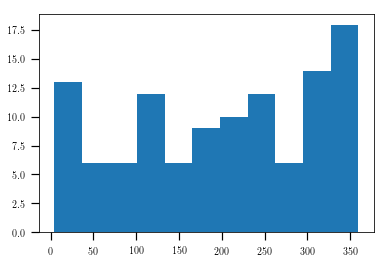

In [45]:
tab['diff_angle_circ'] = (tab['pa_ISO-D']-tab['clus_cen_angle'] + 360)%360
diff_angle_circ = tab['diff_angle_circ']
plt.hist(diff_angle_circ, bins=11)

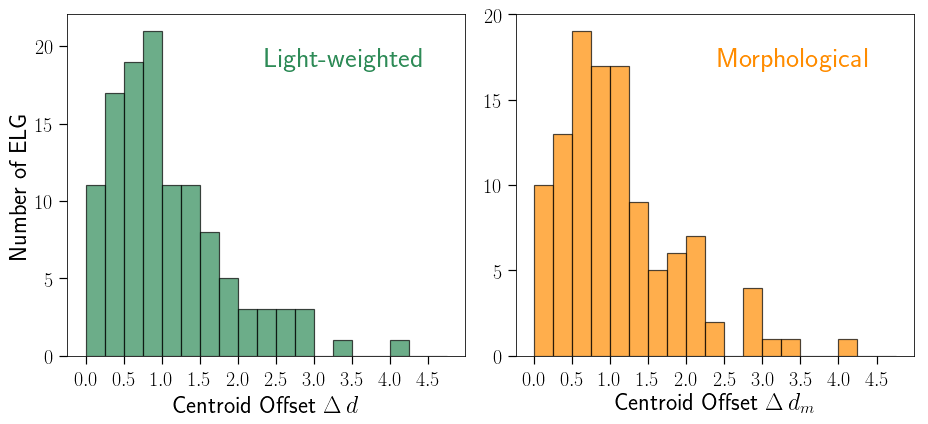

In [5]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(13,6))
props = zip(['seagreen', 'darkorange'], ['','m'],
             ['Light-weighted', 'Morphological'],
             ['cen_offset_ISO-D','cen_offset_ISO-Dm'])
for ax, (color, sub, txt, key) in zip([ax1,ax2], props):
    cen_offset = tab[key]
    ax.hist(cen_offset, bins=np.arange(0,5.,0.25),
             color=color, edgecolor='black', linewidth=1.2, alpha=.7)
    ax.set_xticks(np.arange(0,5.,0.5))
    ax.tick_params(axis="both", labelsize=20)
    ax.text(0.7, 0.85, txt, color=color, ha='center',transform=ax.transAxes, fontsize=28)
    ax.set_xlabel("Centroid Offset  $\Delta\,d_{%s}$"%sub, fontsize=24)
ax2.set_yticks(np.arange(0,22.,5))   
ax1.set_ylabel("Number of ELG", fontsize=24)
plt.tight_layout()
# plt.savefig('./pic/centroid_offset_A2390SN2_5_v4.pdf')

In [28]:
import astropy.units as u
import astropy.constants as c

def V_esc(R, R_vir=1.55*u.Mpc, M_vir=1e14*c.M_sun, C=4):
    s = R/R_vir
    v_esc = np.sqrt(2*c.G*M_vir*K(s,C)/R_vir).to(u.km/u.s)
    return v_esc
    
def K(s,C=4):
    return g_c(C)*np.log(1+C*s)/s

def g_c(C):
    return 1./(np.log(1+C)-C/(1+C))

def Sigma_vir(R_vir, M_vir):
    return np.sqrt(c.G*M_vir/R_vir).to(u.km/u.s)

from astropy.cosmology import FlatLambdaCDM
h = 0.7
cosmo = FlatLambdaCDM(H0=100*h, Om0=0.3)
distance_cluster = cosmo.angular_diameter_distance(z=0.228)
print("Distance to cluster: ", np.around(distance_cluster,2))

M_2390 = 2e15*c.M_sun

len_1arc = distance_cluster*u.arcsec.to(u.rad)
len_pix = len_1arc * 0.322  #pixel length in Mpc
print("Length of a pix", np.around(len_pix.to(u.kpc),2))
print("1 kpc = %.3f pix"%np.around((1/len_pix.to(u.kpc)).value,2))

v_vir_A2390 = 1100 * u.km/u.s #velocity_dispersion
R_vir_A2390 = 1.51 / h * u.Mpc
sigma_v_A2390 = Sigma_vir(R_vir=R_vir_A2390, M_vir=M_2390)
print("R_vir, v_vir:", np.around(R_vir_A2390,2), v_vir_A2390)
print("sigma_v:", np.around(sigma_v_A2390,2))

l_R200_A2390 = (len_pix/R_vir_A2390).value # pixel length in R200 (1 pix = l R_vir)

rr = np.linspace(0.001,8,200) *u.Mpc

Distance to cluster:  752.89 Mpc
Length of a pix 1.18 kpc
1 kpc = 0.850 pix
R_vir, v_vir: 2.16 Mpc 1100.0 km / s
sigma_v: 1996.9 km / s


In [94]:
def separate_member_space(table, cond, z0=0.228, 
                          v_vir=None, l_R200=None,
                          R_vir=None, M_vir=None, C=4,
                          centroid_type='ISO-D', bound_type="inv-sq",
                          r1=1., v1=1., r2=2., v2=3.):
    r_norm = np.array(table['dist_clus_cen']) * l_R200  # normed distance in R200
    v_norm = (abs(np.array(table['z'])-z0) * 3e5*u.km/u.s / v_vir).value # normed vel in v_vir (sigma_vir)
    
    d_cen_v = table['cen_offset'+'_'+centroid_type]
    d_cen_std_v = table['cen_offset'+'_'+centroid_type]
    d_angle_v = table['diff_angle'+'_'+centroid_type]
    
    if bound_type == "escape":
        v_esc = lambda r: V_esc(r, R_vir=R_vir, M_vir=M_vir, C=C)        
        vv = v_esc(r_norm*R_vir)
        sigma_v = Sigma_vir(R_vir=R_vir, M_vir=M_vir)
        in_cluster = v_norm < (vv/sigma_v)   # escape vel
    elif bound_type == "inv-sq":
        in_cluster = ((v_norm/v1) < 1.5*(r_norm/r1)**(-0.5))   # inv-square
    
    cond1 = cond & (d_angle_v<=90) #& in_cluster
    cond2 = cond & (d_angle_v>90) #& in_cluster
    conds_angle = cond1, cond2
    
    virial = ((r_norm/r1)**2 + (v_norm/v1)**2) <= 1.
    non_virial = (~virial) & in_cluster
    inner = ((r_norm/r1)**2 <= 1.) #& in_cluster
    outer = ((r_norm/r1)**2 > 1.) #&  in_cluster
    
    conds_clus = [virial, inner, in_cluster]
    
    return r_norm, v_norm, conds_angle, conds_clus

def draw_phase_diagram(r_norm, v_norm, conds_angle, conds_clus,
                       R_vir=None, r1=1., v1=1., r2=2., v2=3., bound_type="inv-sq",
                       thre=1, ft=22, add_text=True, mec="k", ID=None, ax=None): 
    
    cond1, cond2 = conds_angle
    virial, inner, in_cluster = conds_clus
    non_virial = (~virial) & in_cluster
    
    if ax is None:
        plt.figure(figsize=(10,8))
        ax = plt.subplot(111)
            
    ax.scatter(r_norm[~(cond1|cond2)& in_cluster],
                v_norm[~(cond1|cond2)& in_cluster], s=200, facecolor="gray",
                edgecolor="none",alpha=0.8,zorder=3, label=None)
    ax.scatter(r_norm[cond1 & in_cluster], v_norm[cond1 & in_cluster], lw=2.5, s=250, color="steelblue",
                edgecolor=mec,alpha=0.8,zorder=4,
                label="$\Delta\,d>%.2g$ pix , $\\theta<90^\circ$"%thre)
    ax.scatter(r_norm[cond2 & in_cluster], v_norm[cond2 & in_cluster], lw=2.5, s=250, color="firebrick",
                edgecolor=mec,alpha=0.8,zorder=4,
                label="$\Delta\,d>%.2g$ pix , $\\theta>90^\circ$"%thre)
    
    ax.scatter(r_norm[~(cond1|cond2)& ~in_cluster],
                v_norm[~(cond1|cond2)& ~in_cluster], s=150, lw=3, facecolor="none",
                edgecolor="gray",alpha=0.8,zorder=3, label=None)
    ax.scatter(r_norm[cond1 & ~in_cluster], v_norm[cond1 & ~in_cluster], s=200, lw=3, facecolor="none",
                edgecolor="steelblue",alpha=0.8,zorder=3)
    ax.scatter(r_norm[cond2 & ~in_cluster], v_norm[cond2 & ~in_cluster], s=200, lw=3, facecolor="none",
                edgecolor="firebrick",alpha=0.8,zorder=3)
    
#     condA = non_virial & (r_norm<=1) 
#     condB = virial  
#     condC = non_virial & (r_norm>1)   

#     condA1, condB1, condC1 = condA&cond1, condB&cond1, condC&cond1  
#     condA2, condB2, condC2 = condA&cond2, condB&cond2, condC&cond2 
                  
#     plt.text(0.76, 0.94,"A :",color="k",ha="center",fontsize=ft,transform=ax.transAxes)
#     plt.text(0.76, 0.86,"B :",color="k",ha="center",fontsize=ft,transform=ax.transAxes)
#     plt.text(0.76, 0.78,"C :",color="k",ha="center",fontsize=ft,transform=ax.transAxes)
#     plt.text(0.84, 0.94,"%d"%(np.sum(condA1)),color="steelblue",ha="center",fontsize=ft,transform=ax.transAxes)
#     plt.text(0.84, 0.86,"%d"%(np.sum(condB1)),color="steelblue",ha="center",fontsize=ft,transform=ax.transAxes)
#     plt.text(0.84, 0.78,"%d"%(np.sum(condC1)),color="steelblue",ha="center",fontsize=ft,transform=ax.transAxes)
#     plt.text(0.92, 0.94,"%d"%(np.sum(condA2)),color="firebrick",ha="center",fontsize=ft,transform=ax.transAxes)
#     plt.text(0.92, 0.86,"%d"%(np.sum(condB2)),color="firebrick",ha="center",fontsize=ft,transform=ax.transAxes)
#     plt.text(0.92, 0.78,"%d"%(np.sum(condC2)),color="firebrick",ha="center",fontsize=ft,transform=ax.transAxes)

#     from matplotlib.patches import Ellipse
#     ellipse1 = patches.Ellipse(xy=(0,0), width=2*r1, height=2*v1,
#                                fc='wheat', lw=4, alpha=0.9, zorder=2)
#     ellipse2 = patches.Ellipse(xy=(0,0), width=2*r1, height=2*v1,
#                                edgecolor='orange', fc='none', lw=5, alpha=0.9, zorder=2)
#     [ax.add_patch(p) for p in [ellipse1, ellipse2]]

    xx = np.linspace(0.001, 2.01)
    vv_virial = np.max([np.zeros_like(xx)-0.25, -1.5*xx+1.5], axis=0)
    ax.fill_between(xx, y1=vv_virial, y2=0,color='orange',alpha=0.4,zorder=1)
    ax.plot(xx, vv_virial, color="orange", lw=5, ls="-")
    
#     df = pd.read_csv("/home/qliu/Downloads/Jaffe2018a.csv",header=None)  #Jaffe2018
#     r_Jafa, v_Jafa = df.iloc[:,0], df.iloc[:,1]
#     plt.plot(np.unique(r_Jafa), np.poly1d(np.polyfit(r_Jafa, v_Jafa, 1))(np.unique(r_Jafa)),
#              color="y", lw=5,ls="-",alpha=0.5)

#     df = pd.read_csv("/home/qliu/Downloads/Jaffe2018b.csv",header=None)  #Jaffe2018
#     r_Jafa, v_Jafa = df.iloc[:,0], df.iloc[:,1]
#     plt.plot(np.unique(r_Jafa), np.poly1d(np.polyfit(r_Jafa, v_Jafa, 1))(np.unique(r_Jafa)),
#              color="m", lw=5,ls="-",alpha=0.5)


    if bound_type == "escape":
        ax.fill_between(xx, y1=v_esc(xx*R_vir)/sigma_v, y2=vv_virial, color='seagreen',alpha=0.2,zorder=1)
        ax.plot(rr/R_vir, vv/sigma_v, color="k",lw=5,ls="-")
        ymax = v_esc(R_vir)/sigma_v
    elif bound_type == "inv-sq":
        ax.fill_between(xx, y1=1.5*xx**(-0.5), y2=vv_virial, color='seagreen',alpha=0.2,zorder=1)
        ax.plot(rr/R_vir, 1.5*(rr/R_vir)**(-0.5), color="k",lw=5,ls="-")
        ymax = 1.5
        
    ax.vlines(1, ymin=0.01, ymax=ymax, linestyle="--", color="k", alpha=0.9, lw=3, zorder=2)
    
    if add_text:
        for k, (r, v) in enumerate(zip(r_norm, v_norm)):
            if (r>0) & (cond1[k] | cond2[k]) & in_cluster[k]: 
                ax.text(r+np.random.random()*0.05, v+np.random.random()*0.05,
                         ID[k], fontsize=8)
                
    ax.text(0.05, 0.84,r"$\bf A$",color="k",va="center", fontsize=26,transform=ax.transAxes)
    ax.text(0.05, 0.22,r"$\bf B$",color="k",va="center", fontsize=26,transform=ax.transAxes)
    ax.text(0.88, 0.3,r"$\bf C$",color="k",va="center", fontsize=26,transform=ax.transAxes)

    ax.set_xlim(0.0, r2+0.01), ax.set_ylim(-0.005, v2+0.01)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.set_xlabel("$R\,/\,R_{200}$",fontsize=26)
    ax.set_ylabel("$|v_{los} - v_0| / \sigma_{vir}$",fontsize=26)
#     plt.legend(loc=9,fontsize=14)
    
    plt.tight_layout()

/home/qliu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in less
/home/qliu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in less_equal
/home/qliu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in less_equal
/home/qliu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in greater


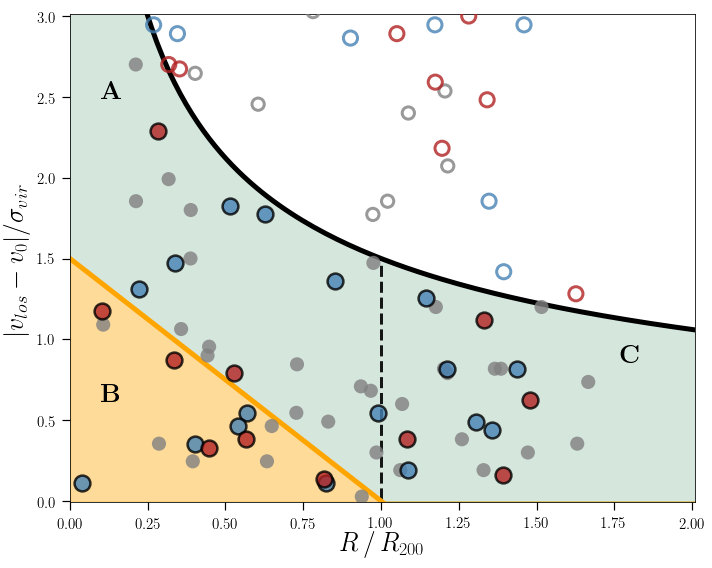

In [46]:
# SN 2.5
cond_func = condition_1
thre = 0.85
cond_iso = cond_func(tab['cen_offset_ISO-D'], tab['cen_offset_std_ISO-D'],
                     tab['z'], z0=0.228, dz=0.015, thre=thre) # 1kpc

r_n, v_n, conds_angle, conds_clus = separate_member_space(tab, cond_iso, z0=0.228,
                                                          v_vir=v_vir_A2390, l_R200=l_R200_A2390,
                                                          R_vir=R_vir_A2390, M_vir=M_2390, 
                                                          bound_type="inv-sq",
                                                          centroid_type='ISO-D')
virial, inner, in_cluster = conds_clus
draw_phase_diagram(r_n, v_n, conds_angle, conds_clus,
                   R_vir=R_vir_A2390, bound_type="inv-sq",
                   thre=thre, add_text=False, ID=tab["ID"])
# plt.savefig('./pic/phase_A2390SN2_5_v4.pdf')

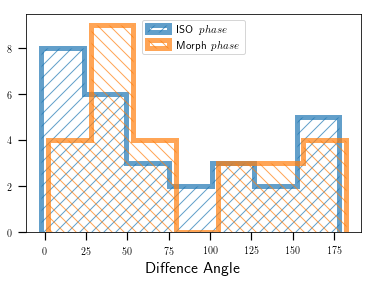

In [47]:
# plt.figure(figsize=(6,5))

cond_iso = cond_func(tab['cen_offset_ISO-D'], tab['cen_offset_std_ISO-D'], tab['z'], thre=thre) # 1 kpc
cond_mor = cond_func(tab['cen_offset_ISO-Dm'], tab['cen_offset_std_ISO-Dm'], tab['z'], thre=thre) # 1 kpc

d_angle_iso = tab['diff_angle_ISO-D'][cond_iso & in_cluster]
d_angle_mor = tab['diff_angle_ISO-Dm'][cond_mor & in_cluster]
plt.hist(d_angle_iso-2, histtype="step", bins=np.linspace(0,180,8)-2, hatch="//", lw=5, alpha=0.7,
        label='ISO $\,phase$',zorder=2)
plt.hist(d_angle_mor+2, histtype="step", bins=np.linspace(0,180,8)+2, hatch="\\\\", lw=5, alpha=0.7,
        label='Morph $\,phase$',zorder=2)

plt.xlabel('Diffence Angle', fontsize=16)

plt.legend(loc=9,fontsize=11)

In [48]:
from scipy.stats import ks_2samp
ks_2samp(d_angle_mor, stats.uniform.rvs(size=10000, loc=0., scale=180))

Ks_2sampResult(statistic=0.20552962962962967, pvalue=0.18122142363247062)

In [49]:
ks_2samp(d_angle_iso, stats.uniform.rvs(size=10000, loc=0., scale=180))

Ks_2sampResult(statistic=0.2527241379310345, pvalue=0.04092317882894428)

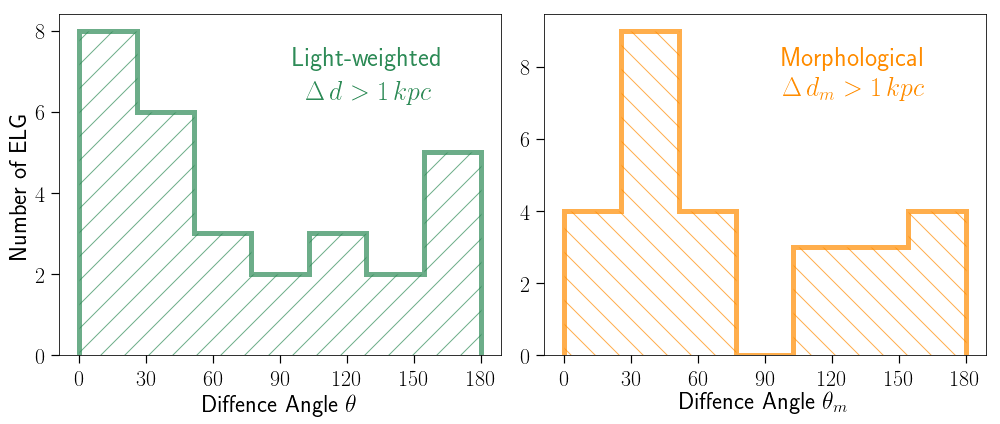

In [51]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,6))
props = zip(['/', '\\'], ['','m'], ['seagreen', 'darkorange'],
            ['Light-weighted', 'Morphological'])
for ax, (hat, sub, color, txt), d_angle in zip([ax1,ax2], props,
                                           [d_angle_iso, d_angle_mor]):
    ax.hist(d_angle, histtype="step", bins=np.linspace(0,180,8),
             color=color, linewidth=1.2, hatch=hat, lw=5, alpha=0.7,zorder=2)

    ax.text(0.7,0.85, txt, color=color, ha='center', transform=ax.transAxes, fontsize=26)
    ax.text(0.7,0.75, '$\Delta\,d_{%s}>1\,kpc$'%sub, color=color, ha='center', transform=ax.transAxes, fontsize=26)
    ax.set_xlabel(r'Diffence Angle  $\theta_{%s}$'%sub, fontsize=24)
    ax.tick_params(axis="both", labelsize=22)
    ax.set_xticks(np.linspace(0,180,7))
    
ax1.set_ylabel("Number of ELG", fontsize=24)
plt.tight_layout()
plt.savefig('./pic/A2390_angle_hist_SN2_5_v4.pdf')

(array([1.04651771, 0.7325624 , 0.52325886, 0.        , 0.31395531,
        0.20930354, 0.        , 0.10465177, 0.        , 0.10465177]),
 array([0.873 , 1.2025, 1.532 , 1.8615, 2.191 , 2.5205, 2.85  , 3.1795,
        3.509 , 3.8385, 4.168 ]),
 <a list of 10 Patch objects>)

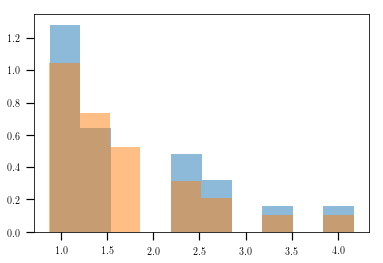

In [38]:
plt.hist(tab[cond_iso & in_cluster & ~virial]['cen_offset_ISO-D'], density=True, alpha=0.5);plt.hist(tab[cond_iso & in_cluster]['cen_offset_ISO-D'],density=True, alpha=0.5)

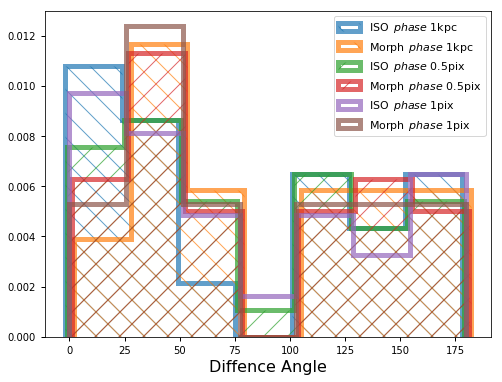

In [55]:
# SN=2.0 mean condition 1
plt.figure(figsize=(8,6))

plt.hist(d_angle_iso_a-2, histtype="step", bins=np.linspace(0,180,8)-2, hatch="\\", lw=5, alpha=0.7,
        label='ISO $\,phase$ 1kpc',density=True, zorder=2)
plt.hist(d_angle_mor_a+2, histtype="step", bins=np.linspace(0,180,8)+2, hatch="\\", lw=5, alpha=0.7,
        label='Morph $\,phase$ 1kpc',density=True, zorder=2)

plt.hist(d_angle_iso_b-1, histtype="step", bins=np.linspace(0,180,8)-1, hatch="/", lw=5, alpha=0.7,
        label='ISO $\,phase$ 0.5pix',density=True, zorder=2)
plt.hist(d_angle_mor_b+1, histtype="step", bins=np.linspace(0,180,8)+1, hatch="/", lw=5, alpha=0.7,
        label='Morph $\,phase$ 0.5pix',density=True, zorder=2)

plt.hist(d_angle_iso, histtype="step", bins=np.linspace(0,180,8), hatch="", lw=5, alpha=0.7,
        label='ISO $\,phase$ 1pix',density=True, zorder=2)
plt.hist(d_angle_mor, histtype="step", bins=np.linspace(0,180,8), hatch="", lw=5, alpha=0.7,
        label='Morph $\,phase$ 1pix',density=True, zorder=2)

plt.xlabel('Diffence Angle', fontsize=16)

plt.legend(ncol=1, loc=1,fontsize=11)
# plt.savefig('./pic/A2390_angle_hist_SN2_5_diff.png')

/home/qliu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in less
/home/qliu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in less_equal
/home/qliu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in less_equal
/home/qliu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in greater


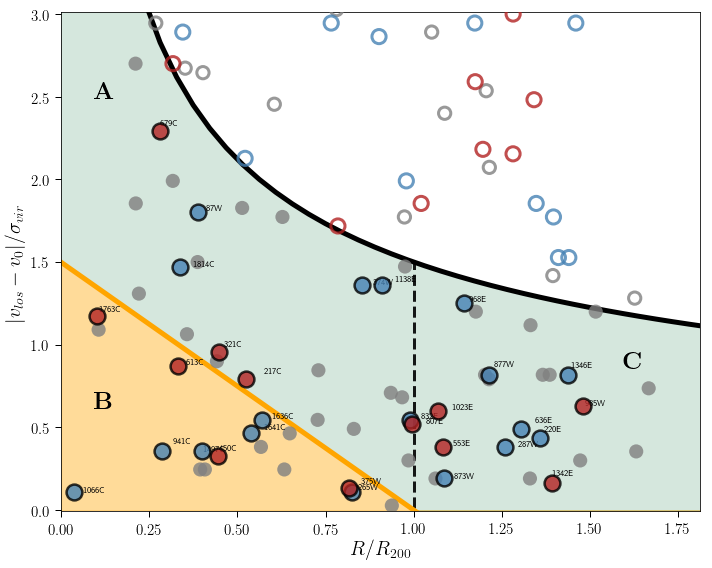

In [15]:
# SN 2.0
cond_func = condition_1
thre = 0.85
cond_iso = cond_func(tab['cen_offset_ISO-D'], tab['cen_offset_std_ISO-D'],
                     tab['z'], thre=thre) # 1kpc

r_n, v_n, conds_angle, conds_clus = separate_member_space(tab, cond_iso,
                                                          bound_type="inv-sq",
                                                          centroid_type='ISO-D')
virial, inner, in_cluster = conds_clus
draw_phase_diagram(r_n, v_n, conds_angle, conds_clus, bound_type="inv-sq",
                   thre=thre, add_text=True, ID=tab["ID"], r2=1.8, v2=3.0)
        
# plt.savefig('./pic/phase_A2390SN2_v3.pdf')

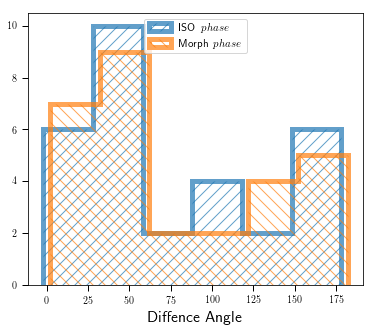

In [19]:
plt.figure(figsize=(6,5))

cond_iso = cond_func(tab['cen_offset_ISO-D'], tab['cen_offset_std_ISO-D'], tab['z'], thre=thre) # 1 kpc
cond_mor = cond_func(tab['cen_offset_ISO-Dm'], tab['cen_offset_std_ISO-Dm'], tab['z'], thre=thre) # 1 kpc

d_angle_iso = tab['diff_angle_ISO-D'][cond_iso & in_cluster]
d_angle_mor = tab['diff_angle_ISO-Dm'][cond_mor & in_cluster]
plt.hist(d_angle_iso-2, histtype="step", bins=np.linspace(0,180,7)-2, hatch="//", lw=5, alpha=0.7,
        label='ISO $\,phase$',zorder=2)
plt.hist(d_angle_mor+2, histtype="step", bins=np.linspace(0,180,7)+2, hatch="\\\\", lw=5, alpha=0.7,
        label='Morph $\,phase$',zorder=2)

plt.xlabel('Diffence Angle', fontsize=16)

plt.legend(loc=9,fontsize=11)

In [12]:
from scipy.stats import ks_2samp
ks_2samp(d_angle_iso, stats.uniform.rvs(size=10000, loc=0., scale=180))

Ks_2sampResult(statistic=0.20129999999999998, pvalue=0.35466018578140257)

In [13]:
ks_2samp(d_angle_mor, stats.uniform.rvs(size=10000, loc=0., scale=180))

Ks_2sampResult(statistic=0.18529999999999996, pvalue=0.32544957285716514)

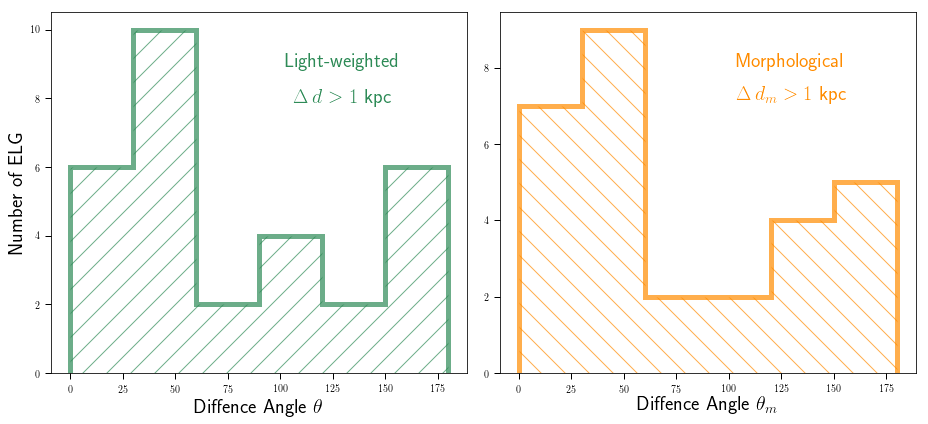

In [25]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(13,6))
props = zip(['/', '\\'], ['','m'], ['seagreen', 'darkorange'],
            ['Light-weighted', 'Morphological'])
for ax, (hat, sub, color, txt), d_angle in zip([ax1,ax2], props,
                                           [d_angle_iso, d_angle_mor]):
    ax.hist(d_angle, histtype="step", bins=np.linspace(0,180,7),
             color=color, linewidth=1.2, hatch=hat, lw=5, alpha=0.7,zorder=2)

    ax.text(0.7,0.85, txt, color=color, ha='center', transform=ax.transAxes, fontsize=20)
    ax.text(0.7,0.75, '$\Delta\,d_{%s}>1$ kpc'%sub, color=color, ha='center', transform=ax.transAxes, fontsize=20)
    ax.set_xlabel(r'Diffence Angle  $\theta_{%s}$'%sub, fontsize=20)

ax1.set_ylabel("Number of ELG", fontsize=20)
plt.tight_layout()
# plt.savefig('./pic/A2390_angle_hist_SN2_v3.pdf')

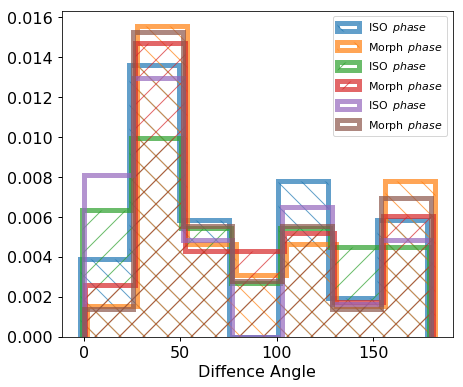

In [162]:
# SN=2.0 mean condition 1
plt.figure(figsize=(7,6))

plt.hist(d_angle_iso_a-2, histtype="step", bins=np.linspace(0,180,8)-2, hatch="\\", lw=5, alpha=0.7,
        label='ISO $\,phase$',density=True, zorder=2)
plt.hist(d_angle_mor_a+2, histtype="step", bins=np.linspace(0,180,8)+2, hatch="\\", lw=5, alpha=0.7,
        label='Morph $\,phase$',density=True, zorder=2)

plt.hist(d_angle_iso_b-1, histtype="step", bins=np.linspace(0,180,8)-1, hatch="/", lw=5, alpha=0.7,
        label='ISO $\,phase$',density=True, zorder=2)
plt.hist(d_angle_mor_b+1, histtype="step", bins=np.linspace(0,180,8)+1, hatch="/", lw=5, alpha=0.7,
        label='Morph $\,phase$',density=True, zorder=2)

plt.hist(d_angle_iso, histtype="step", bins=np.linspace(0,180,8), hatch="", lw=5, alpha=0.7,
        label='ISO $\,phase$',density=True, zorder=2)
plt.hist(d_angle_mor, histtype="step", bins=np.linspace(0,180,8), hatch="", lw=5, alpha=0.7,
        label='Morph $\,phase$',density=True, zorder=2)

plt.xlabel('Diffence Angle', fontsize=16)

plt.legend(ncol=1, loc=1,fontsize=11)

### Spatial Info

In [52]:
header = fits.getheader('./mosaic/J215334.00+174010.0-g.fits')
wcs = WCS(header)

coords_field = np.vstack([[coord.ra.value, coord.dec.value]
                    for coord in [SkyCoord(dc.header["TARGETR"], dc.header["TARGETD"], unit=(u.hourangle,u.deg))
                                           for dc in [datacube_C, datacube_E, datacube_W]]])
cen_field = wcs.all_world2pix(coords_field, 0)

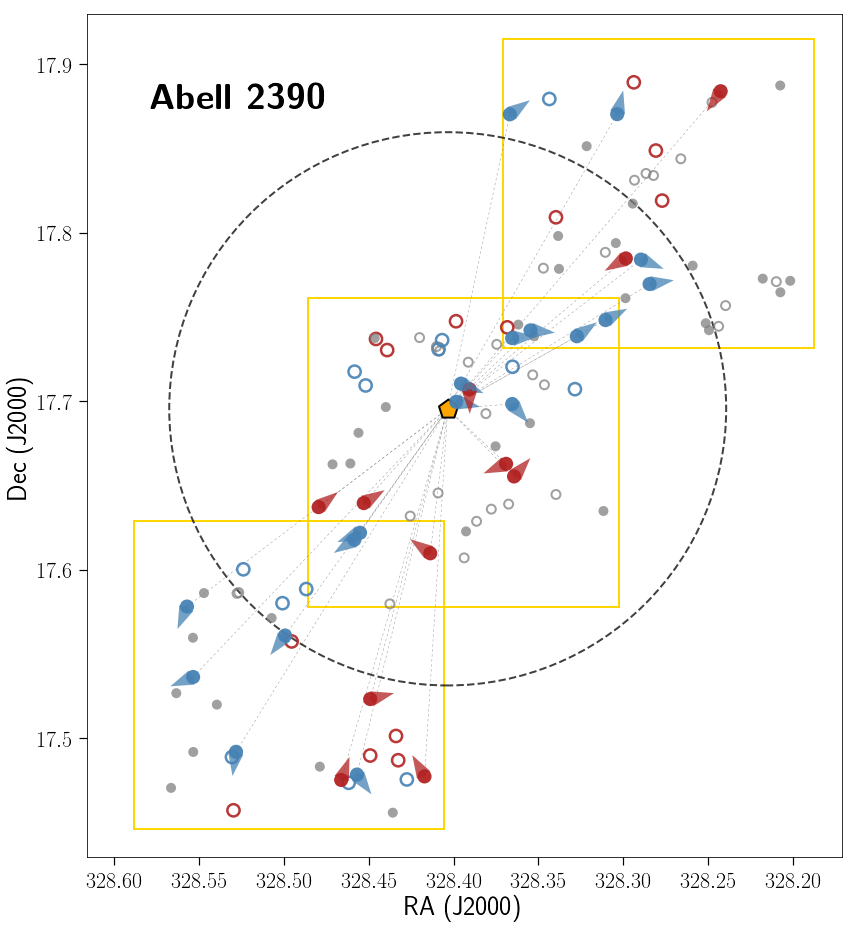

In [57]:
R_vir = R_vir_A2390

fig, ax = plt.subplots(figsize=(12,13))
ax.set_xlim(tab['ra'].max() + 0.015, tab['ra'].min() - 0.015)
ax.set_ylim(tab['dec'].min() - 0.015, tab['dec'].max() + 0.015)
ax.set_xlabel("RA (J2000)", fontsize=26)
ax.set_ylabel("Dec (J2000)", fontsize=26)

coord_BCG = (328.40351201,17.69544013)

plt.scatter(coord_BCG[0], coord_BCG[1], s=400, marker='p', edgecolor="k", color="orange", lw=2, alpha=1,zorder=2)

circle = plt.Circle(coord_BCG, R_vir/len_pix*0.322/3600, color='k', ls="--", lw=2., alpha=0.75, fill=False)
ax.add_artist(circle)
for k, (ID, x, y, pa, theta) in enumerate(zip(tab['ID'], tab['ra'], tab['dec'],
                                              tab['pa_ISO-D'], tab['diff_angle_ISO-D'])):
    color = "steelblue" if theta<90 else "firebrick"
    if (cond_iso & in_cluster)[k]:
        plt.scatter(x, y, s=200, color=color, edgecolors="none", alpha=0.95,zorder=3)
        plt.plot((x,coord_BCG[0]), (y,coord_BCG[1]), color="gray", ls="--", dashes=(5,5),  lw=.5, alpha=0.8, zorder=1)
        plt.arrow(x, y, -np.sin(pa*np.pi/180)*0.001, -np.cos(pa*np.pi/180)*0.001, 
                  fc=color, ec='none', width=0.003, lw=0.5, alpha=0.75, zorder=3)
#         plt.text(x+(np.random.rand()*1-2)*0.002,y+(np.random.rand()*1-2Q)*0.002,'#'+ID,color='k',fontsize=8)
    elif (cond_iso & (~in_cluster))[k]:
        plt.scatter(x, y, s=150, facecolors="none", edgecolors=color, lw=2.5, alpha=0.9,zorder=2)
#         plt.plot((x,coord_BCG[0]), (y,coord_BCG[1]), color="gray", ls="--", dashes=(5,5),  lw=.5, alpha=0.8, zorder=1)
#         plt.arrow(x, y, -np.sin(pa*np.pi/180)*0.001, -np.cos(pa*np.pi/180)*0.001, 
#                   ec=color, width=0.002, lw=0.01, alpha=0.7, zorder=2)
#         plt.text(x+(np.random.rand()*1-2)*0.002,y+(np.random.rand()*1-2)*0.002,'#'+ID,color='k',fontsize=7)
    elif theta>0:
        if (in_cluster)[k]:
            plt.scatter(x, y, s=100, facecolor="gray", edgecolors="none", alpha=0.75, zorder=2)
        else:
            plt.scatter(x, y, s=80, facecolor='none', lw=2, color="gray", alpha=0.75, zorder=2)

L_field = 1024*len_pix/distance_cluster*180/np.pi
for cen in coords_field:
    rec = patches.Rectangle((cen[0]-L_field, cen[1]-L_field), 2*L_field, 2*L_field,
                            linewidth=2, edgecolor='gold', facecolor='none', zorder=1)
    ax.add_patch(rec)
ax.text(0.2, 0.9, r'\textbf{Abell 2390}', ha='center', va='center', fontsize=36, transform=ax.transAxes)
ax.tick_params(axis="both", labelsize=22)

p1, p2, p3, p4 = wcs.calc_footprint()
plt.xlim(p1[0]-0.04, p3[0]+0.04)
plt.ylim(p1[1]+0.01, p2[1]+0.01)
plt.tight_layout()
# plt.savefig('./pic/spatial_A2390_SN2_5_v4.pdf')

/home/qliu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in less
/home/qliu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in less_equal
/home/qliu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in less_equal
/home/qliu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in greater


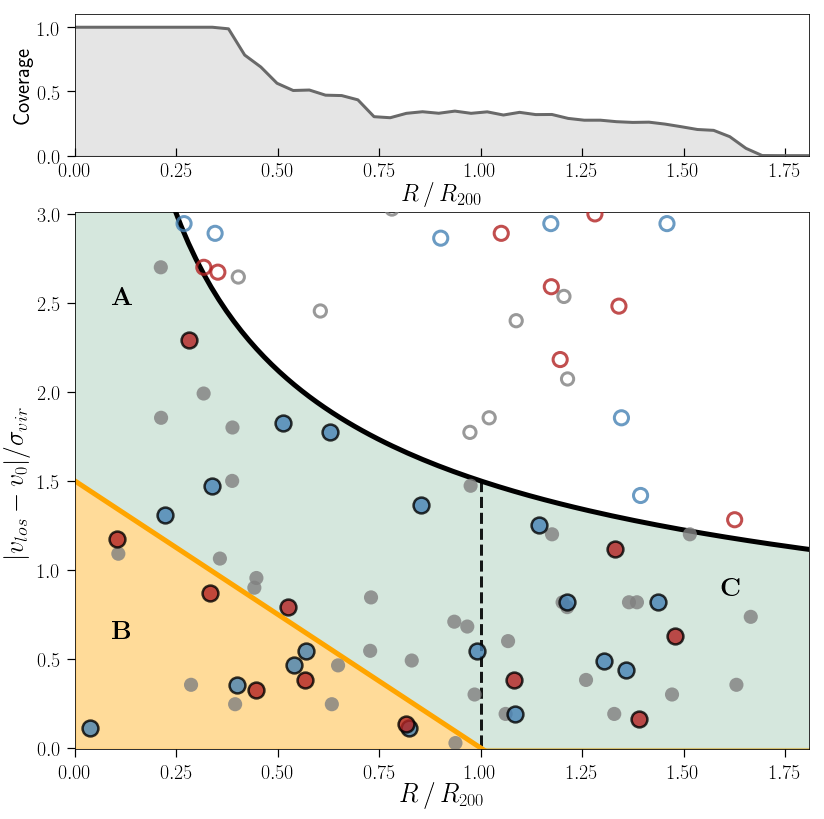

In [59]:
# SN 2.0
cond_func = condition_1
thre = 0.85
cond_iso = cond_func(tab['cen_offset_ISO-D'], tab['cen_offset_std_ISO-D'],
                     tab['z'], thre=thre) # 1kpc

r_n, v_n, conds_angle, conds_clus = separate_member_space(tab, cond_iso,
                                                          v_vir=v_vir_A2390, l_R200=l_R200_A2390,
                                                          R_vir=R_vir_A2390, M_vir=M_2390, 
                                                          bound_type="inv-sq",
                                                          centroid_type='ISO-D')
virial, inner, in_cluster = conds_clus

plt.figure(figsize=(12,12))
ax = plt.subplot2grid((4, 1), (1, 0), rowspan=3)
draw_phase_diagram(r_n, v_n, conds_angle, conds_clus, R_vir=R_vir_A2390, bound_type="inv-sq",
                   thre=thre, add_text=False, ID=tab["ID"], r2=1.8, v2=3.0, ax=ax)
ax.tick_params(axis="both", labelsize=20)

ax2 = plt.subplot2grid((4, 1), (0, 0), rowspan=1, sharex=ax)
ax2.plot(np.insert(R_vir_bin, 0, 0), np.insert(frac_cover, 0, 1), lw=3, color="dimgray") 
ax2.fill_between(np.insert(R_vir_bin, 0, 0), np.insert(frac_cover, 0, 1), 0, color="gray", alpha=0.2) 
ax2.tick_params(axis="x", direction="in")
ax2.tick_params(axis="both", labelsize=20)
ax2.set_xlabel("$R\,/\,R_{200}$", fontsize=24)
ax2.set_ylabel("Coverage", fontsize=22)
ax2.set_ylim(0,1.1)

plt.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1, hspace=0.4)
plt.savefig('./pic/phase_A2390SN2_5_v4.pdf')

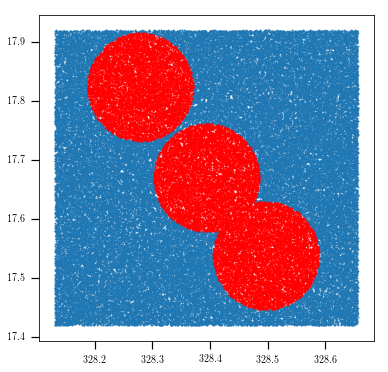

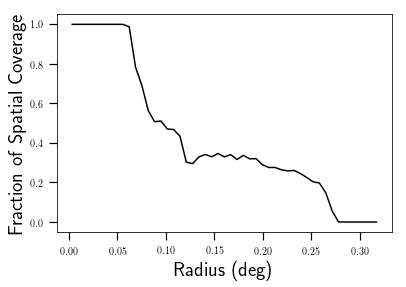

In [58]:
def calculate_coverage(coords_field, coord_BCG, field_radius, wcs, plot=True):
    L_field = 1024*len_pix/distance_cluster*180/np.pi

    p1, p2, p3, p4 = wcs.calc_footprint()

    rv_ra = stats.uniform(loc=p3[0], scale=p1[0]-p3[0])
    rv_dec = stats.uniform(loc=p1[1], scale=p2[1]-p1[1])

    rvs_ra, rvs_dec = rv_ra.rvs(100000), rv_dec.rvs(100000)
    covered = np.logical_or.reduce([np.hypot(rvs_ra-coord[0], rvs_dec-coord[1]) <= field_radius
                                    for coord in coords_field], axis=0)
    
    bins = np.linspace(0, 3.5*field_radius, 50)
    r_bin = (bins[1:] + bins[:-1]) / 2
    r = np.hypot(rvs_ra-coord_BCG[0], rvs_dec-coord_BCG[1])
    hist_all, _ = np.histogram(r, bins)
    hist_covered, _ = np.histogram(r[covered], bins)
    frac_cover = hist_covered / hist_all
    
    if plot:
        plt.figure(figsize=(6,6))
        plt.scatter(rvs_ra[~covered], rvs_dec[~covered], s=1, alpha=0.8)
        plt.scatter(rvs_ra[covered], rvs_dec[covered], c="r", s=1, alpha=0.8)
        plt.figure(figsize=(6,4))
        plt.plot(r_bin, frac_cover, "k-")
        plt.ylabel("Fraction of Spatial Coverage")
        plt.xlabel("Radius (deg)")
        
    return r_bin, frac_cover

r_bin, frac_cover = calculate_coverage(coords_field, coord_BCG, L_field, wcs)
R_vir_bin = r_bin*distance_cluster/180*np.pi/R_vir

#### S/N = 2.0

In [36]:
fig, ax = plt.subplots(figsize=(10,10.5))
ax.set_xlim(tab['ra'].max() + 0.015, tab['ra'].min() - 0.015)
ax.set_ylim(tab['dec'].min() - 0.015, tab['dec'].max() + 0.015)
ax.set_xlabel("RA (J2000)", fontsize=20)
ax.set_ylabel("Dec (J2000)", fontsize=20)

coord_BCG = (328.40351201,17.69544013)

plt.scatter(coord_BCG[0], coord_BCG[1], s=400, marker='p', edgecolor="k", color="orange", lw=2, alpha=1,zorder=2)

circle = plt.Circle(coord_BCG, R_vir/len_pix*0.322/3600, color='k', ls="--", lw=2., alpha=0.5, fill=False)
ax.add_artist(circle)
for k, (ID, x, y, pa, theta) in enumerate(zip(tab['ID'], tab['ra'], tab['dec'],
                                              tab['pa_ISO-D'], tab['diff_angle_ISO-D'])):
    color = "steelblue" if theta<90 else "firebrick"
    if (cond_iso & in_cluster)[k]:
        plt.scatter(x, y, s=150, color=color, edgecolors="none", alpha=0.95,zorder=3)
        plt.plot((x,coord_BCG[0]), (y,coord_BCG[1]), color="gray", ls="--", dashes=(5,5),  lw=.5, alpha=0.8, zorder=1)
        plt.arrow(x, y, -np.sin(pa*np.pi/180)*0.001, -np.cos(pa*np.pi/180)*0.001, 
                  fc=color, ec='none', width=0.003, lw=0.5, alpha=0.75, zorder=3)
#         plt.text(x+(np.random.rand()*1-2)*0.002,y+(np.random.rand()*1-2Q)*0.002,'#'+ID,color='k',fontsize=8)
    elif (cond_iso & (~in_cluster))[k]:
        plt.scatter(x, y, s=100, facecolors="none", edgecolors=color, lw=2, alpha=0.9,zorder=2)
#         plt.plot((x,coord_BCG[0]), (y,coord_BCG[1]), color="gray", ls="--", dashes=(5,5),  lw=.5, alpha=0.8, zorder=1)
#         plt.arrow(x, y, -np.sin(pa*np.pi/180)*0.001, -np.cos(pa*np.pi/180)*0.001, 
#                   ec=color, width=0.002, lw=0.01, alpha=0.7, zorder=2)
#         plt.text(x+(np.random.rand()*1-2)*0.002,y+(np.random.rand()*1-2)*0.002,'#'+ID,color='k',fontsize=7)
    elif theta>0:
        if (in_cluster)[k]:
            plt.scatter(x, y, s=80, facecolor="gray", edgecolors="none", alpha=0.75, zorder=2)
        else:
            plt.scatter(x, y, s=50, facecolor='none', lw=2, color="gray", alpha=0.75, zorder=2)

L_field = 1024*len_pix/distance_cluster*180/np.pi
for cen in coords_field:
    rec = patches.Rectangle((cen[0]-L_field, cen[1]-L_field), 2*L_field, 2*L_field,
                            linewidth=2, edgecolor='gold', facecolor='none', zorder=1)
    ax.add_patch(rec)

p1, p2, p3, p4 = wcs.calc_footprint()
plt.xlim(p1[0]-0.04, p3[0]+0.04)
plt.ylim(p1[1]+0.01, p2[1]+0.01)
plt.tight_layout()
# plt.savefig('./pic/spatial_A2390_SN2_v3.pdf')

/home/qliu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in less
/home/qliu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in less_equal
/home/qliu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in less_equal
/home/qliu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in greater


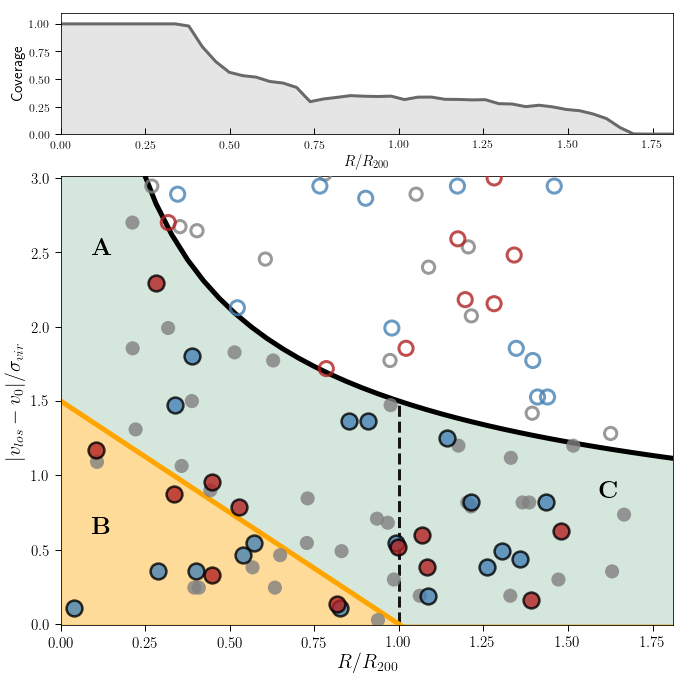

In [30]:
# SN 2.0
cond_func = condition_1
thre = 0.85
cond_iso = cond_func(tab['cen_offset_ISO-D'], tab['cen_offset_std_ISO-D'],
                     tab['z'], thre=thre) # 1kpc

r_n, v_n, conds_angle, conds_clus = separate_member_space(tab, cond_iso,
                                                          bound_type="inv-sq",
                                                          centroid_type='ISO-D')
virial, inner, in_cluster = conds_clus

plt.figure(figsize=(10,10))
ax = plt.subplot2grid((4, 1), (1, 0), rowspan=3)
draw_phase_diagram(r_n, v_n, conds_angle, conds_clus, bound_type="inv-sq",
                   thre=thre, add_text=False, ID=tab["ID"], r2=1.8, v2=3.0, ax=ax)
ax2 = plt.subplot2grid((4, 1), (0, 0), rowspan=1, sharex=ax)
ax2.plot(np.insert(R_vir_bin, 0, 0), np.insert(frac_cover, 0, 1), lw=3, color="dimgray") 
ax2.fill_between(np.insert(R_vir_bin, 0, 0), np.insert(frac_cover, 0, 1), 0, color="gray", alpha=0.2) 
ax2.tick_params(axis="x", direction="in")
ax2.tick_params(axis="both", labelsize=12)
ax2.set_xlabel("$R / R_{200}$", fontsize=15)
ax2.set_ylabel("Coverage", fontsize=15)
ax2.set_ylim(0,1.1)

plt.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1, hspace=0.35)
# plt.savefig('./pic/phase_A2390SN2_v3.pdf')

Continuum non-subtracted

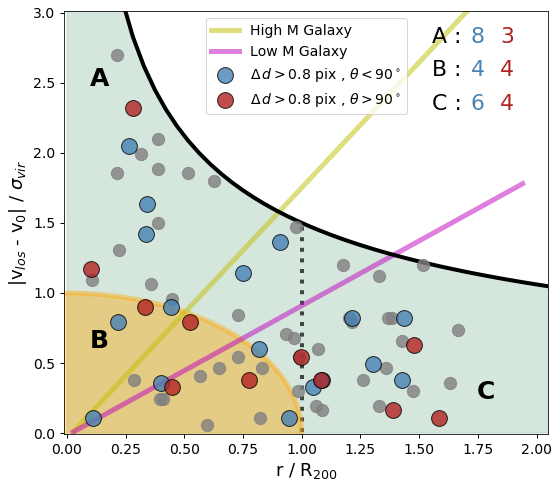

In [286]:
# SN 2.0 mean continuum non-subtracted
cond_func = condition_1
thre = 0.85
cond_iso = cond_func(tab['cen_offset_ISO-D'], tab['cen_offset_std_ISO-D'], tab['z'], thre=thre) # 1kpc

r_n, v_n, conds_angle, conds_clus = separate_member_space(tab, cond_iso,
                                                          bound_type="inv-sq",
                                                          centroid_type='ISO-D')
virial, inner, in_cluster = conds_clus
draw_phase_diagram(r_n, v_n, conds_angle, conds_clus, bound_type="inv-sq",
                   thre=thre, add_text=False)

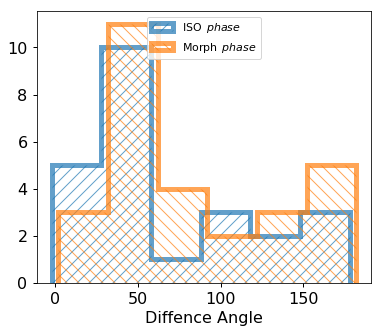

In [434]:
plt.figure(figsize=(6,5))

cond_iso = cond_func(tab['cen_offset_ISO-D'], tab['cen_offset_std_ISO-D'], tab['z'], thre=thre) # 1 kpc
cond_mor = cond_func(tab['cen_offset_ISO-Dm'], tab['cen_offset_std_ISO-Dm'], tab['z'], thre=thre) # 1 kpc

d_angle_iso = tab['diff_angle_ISO-D'][cond_iso & in_cluster]
d_angle_mor = tab['diff_angle_ISO-Dm'][cond_mor & in_cluster]
plt.hist(d_angle_iso-2, histtype="step", bins=np.linspace(0,180,7)-2, hatch="//", lw=5, alpha=0.7,
        label='ISO $\,phase$',zorder=2)
plt.hist(d_angle_mor+2, histtype="step", bins=np.linspace(0,180,7)+2, hatch="\\\\", lw=5, alpha=0.7,
        label='Morph $\,phase$',zorder=2)

plt.xlabel('Diffence Angle', fontsize=16)

plt.legend(loc=9,fontsize=11)

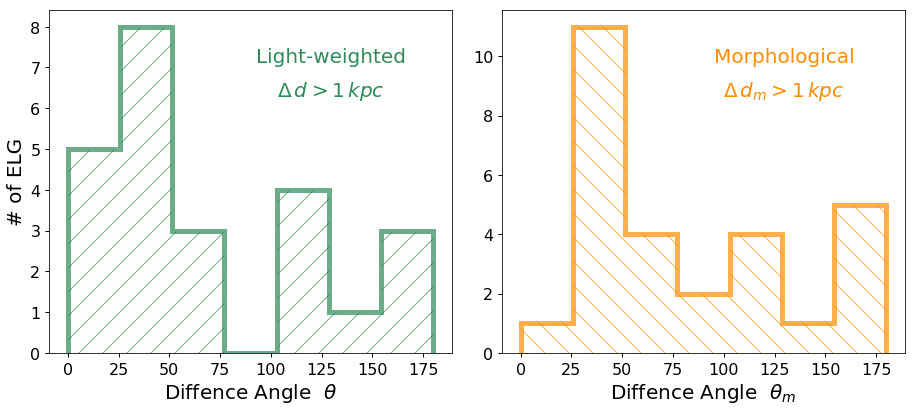

In [438]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(13,6))
props = zip(['/', '\\'], ['','m'], ['seagreen', 'darkorange'],
            ['Light-weighted', 'Morphological'])
for ax, (hat, sub, c, txt), d_angle in zip([ax1,ax2], props,
                                           [d_angle_iso, d_angle_mor]):
    ax.hist(d_angle, histtype="step", bins=np.linspace(0,180,8),
             color=c, linewidth=1.2, hatch=hat, lw=5, alpha=0.7,zorder=2)

    ax.text(0.7,0.85, txt, color=c, ha='center', transform=ax.transAxes, fontsize=20)
    ax.text(0.7,0.75, '$\Delta\,d_{%s}>1\,kpc$'%sub, color=c, ha='center', transform=ax.transAxes, fontsize=20)
    ax.set_xlabel(r'Diffence Angle  $\theta_{%s}$'%sub, fontsize=20)

ax1.set_ylabel("# of ELG", fontsize=20)
plt.tight_layout()
plt.savefig('./pic/A2390_angle_hist.pdf')

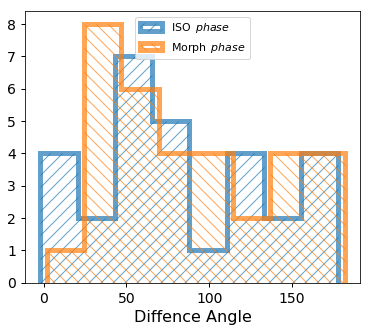

In [287]:
plt.figure(figsize=(6,5))

cond_iso = cond_func(tab['cen_offset_ISO-D'], tab['cen_offset_std_ISO-D'], tab['z'], thre=thre) # 1 kpc
cond_mor = cond_func(tab['cen_offset_ISO-Dm'], tab['cen_offset_std_ISO-Dm'], tab['z'], thre=thre) # 1 kpc

d_angle_iso = tab['diff_angle_ISO-D'][cond_iso & in_cluster]
d_angle_mor = tab['diff_angle_ISO-Dm'][cond_mor & in_cluster]
plt.hist(d_angle_iso-2, histtype="step", bins=np.linspace(0,180,9)-2, hatch="//", lw=5, alpha=0.7,
        label='ISO $\,phase$',zorder=2)
plt.hist(d_angle_mor+2, histtype="step", bins=np.linspace(0,180,9)+2, hatch="\\\\", lw=5, alpha=0.7,
        label='Morph $\,phase$',zorder=2)

plt.xlabel('Diffence Angle', fontsize=16)

plt.legend(loc=9,fontsize=11)

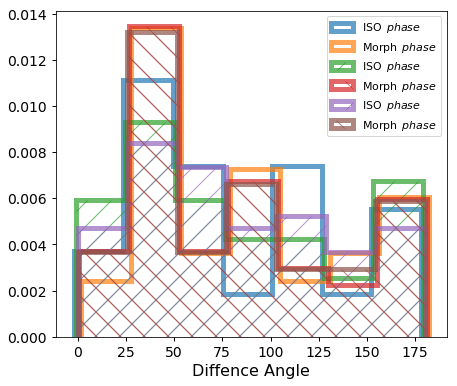

In [152]:
# SN=2.0 mean condition 1
plt.figure(figsize=(7,6))

plt.hist(d_angle_iso_a-2, histtype="step", bins=np.linspace(0,180,8)-2, hatch="", lw=5, alpha=0.7,
        label='ISO $\,phase$',density=True, zorder=2)
plt.hist(d_angle_mor_a+2, histtype="step", bins=np.linspace(0,180,8)+2, hatch="", lw=5, alpha=0.7,
        label='Morph $\,phase$',density=True, zorder=2)

plt.hist(d_angle_iso_b-1, histtype="step", bins=np.linspace(0,180,8)-1, hatch="/", lw=5, alpha=0.7,
        label='ISO $\,phase$',density=True, zorder=2)
plt.hist(d_angle_mor_b+1, histtype="step", bins=np.linspace(0,180,8)+1, hatch="\\", lw=5, alpha=0.7,
        label='Morph $\,phase$',density=True, zorder=2)

plt.hist(d_angle_iso, histtype="step", bins=np.linspace(0,180,8), hatch="/", lw=5, alpha=0.7,
        label='ISO $\,phase$',density=True, zorder=2)
plt.hist(d_angle_mor, histtype="step", bins=np.linspace(0,180,8), hatch="\\", lw=5, alpha=0.7,
        label='Morph $\,phase$',density=True, zorder=2)

plt.xlabel('Diffence Angle', fontsize=16)

plt.legend(ncol=1, loc=1,fontsize=11)

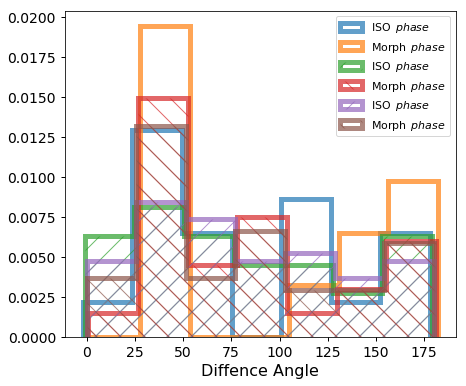

In [144]:
# SN=2.0 mean condition 2

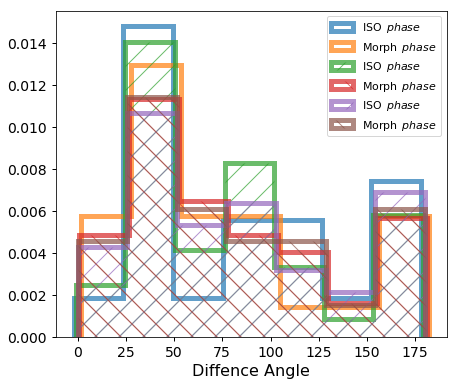

In [164]:
# SN=2.0 weighted condition 1

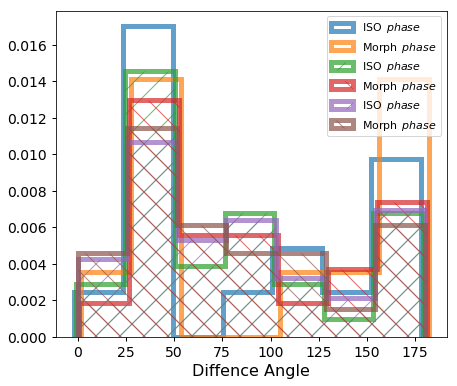

In [176]:
# SN=2.0 weighted condition 2

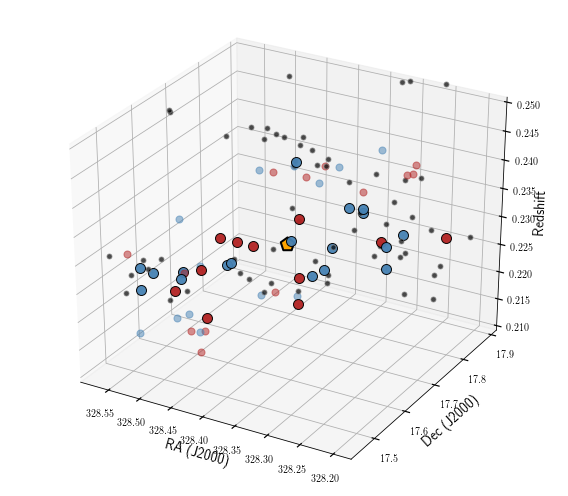

In [61]:
# %matplotlib notebook
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D 

fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlim(tab['ra'].max() + 0.02, tab['ra'].min() - 0.02)
ax.set_ylim(tab['dec'].min() - 0.02, tab['dec'].max() + 0.02)
ax.set_zlim(0.21,0.25)
ax.set_xlabel("RA (J2000)", fontsize=14)
ax.set_ylabel("Dec (J2000)", fontsize=14)
ax.set_zlabel("Redshift", fontsize=14)

coord_BCG = (328.40351201,17.69544013)

ax.scatter(coord_BCG[0], coord_BCG[1], 0.228, s=200, marker='p', color="orange", edgecolor="k", lw=2, alpha=1,zorder=2)

for k, (ID, x, y, z, pa, theta) in enumerate(zip(tab['ID'], tab['ra'], tab['dec'], tab['z'],
                                               tab['pa_ISO-D'], tab['diff_angle_ISO-D'])):
    color = "steelblue" if theta<90 else "firebrick"
    if (cond_iso& in_cluster)[k]:
        ax.scatter(x, y, z, s=100, color=color, edgecolors="none", alpha=0.95,zorder=4)
#         ax.plot((coord_BCG[0],x), (coord_BCG[1],y), (0.228,z), color="gray", ls="--", dashes=(5,5), lw=.5, alpha=0.8, zorder=1)
#         ax.arrow(x, y, z, -np.sin(pa*np.pi/180)*0.001, -np.cos(pa*np.pi/180)*0.001, 0,
#                   color=color, width=0.0025, lw=0.01, alpha=0.7, zorder=2)
        ax.quiver(x, y, z, -np.sin(pa*np.pi/180)*0.001, -np.cos(pa*np.pi/180)*0.001, 0,
                  color=color, length=0.1, alpha=0.7, zorder=4)
#         plt.text(x+(np.random.rand()*1-2)*0.002,y+(np.random.rand()*1-2)*0.002,'#'+ID,color='k',fontsize=8)
    elif (cond_iso & (~in_cluster))[k]:
        ax.scatter(x, y, z, s=50,  color=color, alpha=0.5,zorder=3)
#         ax.arrow(x, y, z, -np.sin(pa*np.pi/180)*0.001, -np.cos(pa*np.pi/180)*0.001, 0,
#                   ec=color, fc="none", width=0.002, lw=0.01, alpha=0.7, zorder=2)
#         plt.text(x+(np.random.rand()*1-2)*0.002,y+(np.random.rand()*1-2)*0.002,'#'+ID,color='k',fontsize=7)
    elif theta>0:
        ax.scatter(x, y, z, s=25, facecolor='none', color="gray", alpha=0.7, zorder=2)
plt.tight_layout()

# A2465C

In [62]:
datacube_D = Read_Datacube('./output1/A2465C/A2465C_cube_lpf.fits', 
                         name='A2465C', z0=0.245, mode="MMA",
                         table='./output1/A2465C/A2465C_MMA_lpf.dat',
                         deep_frame='./output/A2465C/A2465C_DF.fits',
                         seg_map='./output1/A2465C/A2465C_segm_MMA_lpf.fits',
                         mask_edge='./output/A2465C/Raw_stack_A2465C_mask.fits')

datacube_D.get_wcs()
datacube_D.read_cluster_boundary("./A2465C/A2465C_bound_v2.fits")
datacube_D.src_map = fits.open('./output1/A2465C/A2465C_MMA_lpf.fits')[0].data
datacube_D.read_spec('./output1/A2465C/A2465C-spec-MMA_lpf.fits')
datacube_D.read_template('./output1/template/', n_intp=2, name='A2465C')
datacube_D.read_cc_result('./output1/A2465C/A2465C-cc-MMA_lpf.pkl')

Z_bound = fits.getdata('./A2465C/A2465C_bound_v2.fits').astype("int")

id_BCG1 = np.argmin((datacube_D.table["xcentroid"]-707)**2 + (datacube_D.table["ycentroid"]-1385)**2)
id_BCG2 = np.argmin((datacube_D.table["xcentroid"]-1446)**2 + (datacube_D.table["ycentroid"]-679)**2)
pos_BCG = np.array(datacube_D.assign_BCG_position(id_BCG=[id_BCG1,id_BCG2]))

Read Emission Line Template:
['./output1/template/Template-A2465C_Ha-NII_gauss.fits',
 './output1/template/Template-A2465C_Hb-OIII_gauss.fits',
 './output1/template/Template-A2465C_OII_gauss.fits']
Read cross-correlation results for A2465C from : ./output1/A2465C/A2465C-cc-MMA_lpf.pkl
Template used: ['Ha-NII_gauss', 'Hb-OIII_gauss', 'OII_gauss']


In [10]:
datacube_D.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                 2048                                                  
NAXIS2  =                 2064                                                  
NAXIS3  =                   95                                                  
DATE    = '2019-01-29'         / Creation date                                  
MASK    = 'False   '                                                            
FILETYPE= 'Calibrated Spectrum Cube' / Type of file                             
OBSERVAT= 'CFHT    '           / Observatory name                               
TELESCOP= 'CFHT 3.6m'          / Hawaii Big Island, Mauna Kea                   
INSTRUME= 'SITELLE '           / Instrument Name                                
ORBSVER = '' / ORBS version 

In [104]:
from astropy.cosmology import FlatLambdaCDM
import astropy.constants as c
h = 0.7
cosmo = FlatLambdaCDM(H0=100*h, Om0=0.3)
distance_cluster = cosmo.angular_diameter_distance(z=0.245)
print(distance_cluster)

len_1arc = distance_cluster*u.arcsec.to(u.rad)
len_pix = len_1arc * 0.322  #pixel length in Mpc
print(len_pix)
print("1kpc = %.3f pix"%(1/len_pix.to(u.kpc)).value)

v_vir_A2465 = 740 * u.km/u.s #velocity_dispersion
R_vir_A2465 = 1.2 * u.Mpc
print(R_vir_A2465, v_vir_A2465)

l_R200_A2465 = (len_pix/R_vir_A2465).value # pixel length in R200 1 pix = l R_vir
print(l_R200_A2465)

M_A2465 = 3e14*c.M_sun
rr = np.linspace(0.001,8,200) *u.Mpc
vv_A2465 = V_esc(rr, R_vir=R_vir_A2465, M_vir=M_A2465, C=6) # C from Allen2000

794.562953587183 Mpc
0.0012403922690940134 Mpc
1kpc = 0.806 pix
1.2 Mpc 740.0 km / s
0.0010336602242450113


In [64]:
tab_A2465C = Table.read('./output1/A2465C/centroid_analysis_A2465C_mean_sn2.5_contsub_lpf_NB.txt', format='ascii')
set_radius(tab_A2465C, datacube_D)

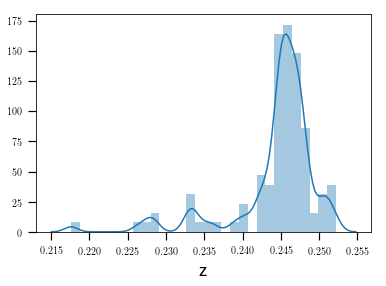

In [65]:
sns.distplot(tab_A2465C['z'])

/home/qliu/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


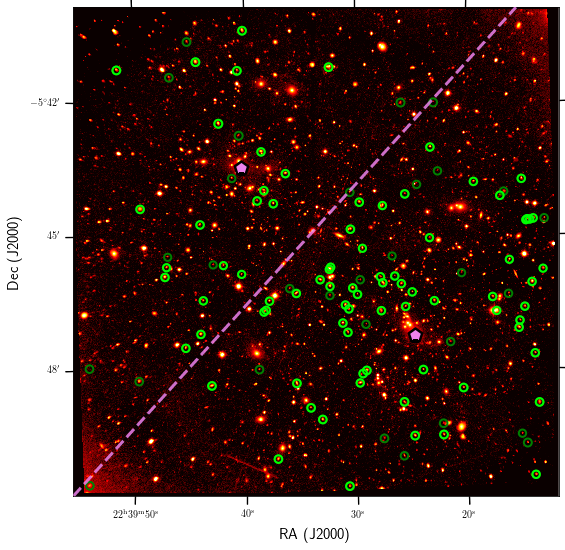

In [66]:
fig = plt.figure(figsize=(9,9))
ax = plt.subplot(111, projection=datacube_D.wcs)
ax.scatter(pos_BCG[:,0], pos_BCG[:,1], s=200, color="violet", edgecolor="k", marker="p", linewidth=2.5)

plt.scatter(tab_A2465C['X'], tab_A2465C['Y'], s=tab_A2465C['radius']*20+20,
            facecolor="none", edgecolor="g", linewidth=2)

tab_iso = tab_A2465C[tab_A2465C['cen_offset_ISO-D']>0]
ax.scatter(tab_iso['X'], tab_iso['Y'], s=tab_iso['radius']*20+20, facecolor="none", edgecolor="lime", linewidth=2)
ax.imshow(datacube_D.deep_frame, norm=AsinhNorm(0.01), cmap='hot',
          vmin=np.median(datacube_D.deep_frame), vmax=5e2)

X_bound = np.arange(0,2048,1)
Y_bound = np.argmin(Z_bound, axis=0)
bound = Y_bound>0
plt.plot(X_bound[bound], Y_bound[bound], color='violet', lw=3, ls='--', alpha=0.85)

plt.xlabel("RA (J2000)", fontsize=15)
plt.ylabel("Dec (J2000)", fontsize=15)

# plt.savefig('./pic/A2465_Field_ELG_v3.pdf')

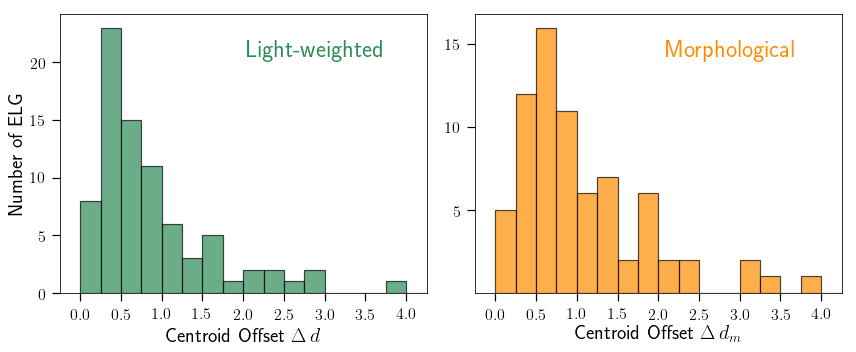

In [67]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5))
props = zip(['seagreen', 'darkorange'], ['','m'],
             ['Light-weighted', 'Morphological'],
             ['cen_offset_ISO-D','cen_offset_ISO-Dm'])
for ax, (color, sub, txt, key) in zip([ax1,ax2], props):
    cen_offset = tab_A2465C[key]
    ax.hist(cen_offset, bins=np.arange(0,5,0.25),
             color=color, edgecolor='black', linewidth=1.2, alpha=.7)
    ax.set_xticks(np.arange(0,5.,0.5))
    ax.text(0.7, 0.85, txt, color=color, ha='center',transform=ax.transAxes, fontsize=24)
    ax.tick_params(axis="both", labelsize=16)
    ax.set_xlabel("Centroid Offset  $\Delta\,d_{%s}$"%sub, fontsize=20)
    ax.set_xlim(-0.25, 4.25)   

ax2.set_yticks(np.arange(5., 20, 5))
ax1.set_ylabel("Number of ELG", fontsize=20)
plt.tight_layout()
# plt.savefig('./pic/centroid_offset_A2465_SN2_5_v3.pdf')

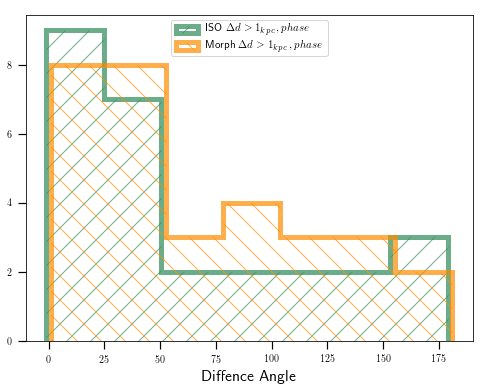

In [71]:
plt.figure(figsize=(8,6))
thre = 0.81
cond_iso = condition_1(tab_A2465C['cen_offset_ISO-D'], tab_A2465C['cen_offset_std_ISO-D'], tab_A2465C['z'],
                       z0=0.245, dz=0.015, thre=thre) # 1 kpc
cond_mor = condition_1(tab_A2465C['cen_offset_ISO-Dm'], tab_A2465C['cen_offset_std_ISO-Dm'], tab_A2465C['z'],
                       z0=0.245, dz=0.015, thre=thre) # 1 kpc

d_angle_iso = tab_A2465C['diff_angle_ISO-D'][cond_iso]
d_angle_mor = tab_A2465C['diff_angle_ISO-Dm'][cond_mor]
plt.hist(d_angle_iso-1, histtype="step", bins=np.linspace(0,180,8)-1,
         linewidth=1.2, hatch="/", lw=5, alpha=0.7,
         color='seagreen', label='ISO $\Delta d>1_{kpc}\,,phase$',zorder=2)
plt.hist(d_angle_mor+1, histtype="step", bins=np.linspace(0,180,8)+1,
         color='darkorange', linewidth=1.2, hatch="\\", lw=5, alpha=0.7,
         label='Morph $\Delta d>1_{kpc}\,,phase$',zorder=2)

plt.xlabel('Diffence Angle', fontsize=16)
plt.legend(loc=9,fontsize=11)

/home/qliu/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)
/home/qliu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in less
/home/qliu/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in less_equal
  result = getattr(super(), op)(other)
/home/qliu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in less_equal
/home/qliu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in less_equal
/home/qliu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in greater


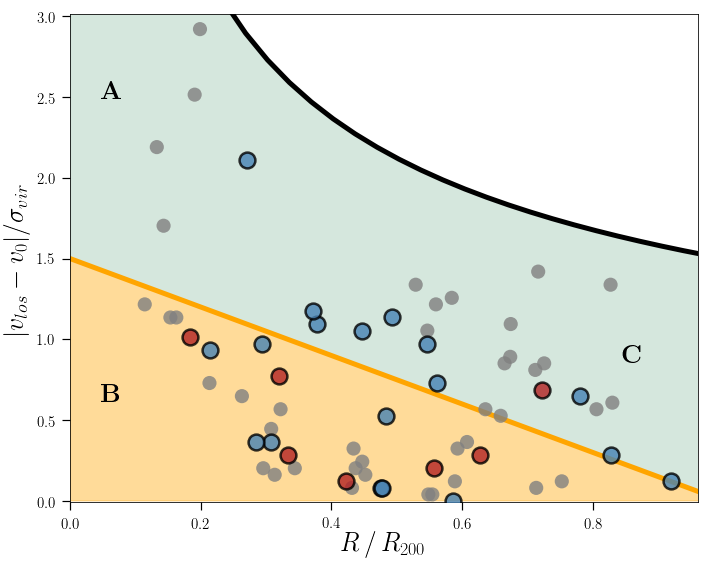

In [105]:
# SN 2.5
cond_func = condition_1
thre = 0.81

cond_iso = cond_func(tab_A2465C['cen_offset_ISO-D'], tab_A2465C['cen_offset_std_ISO-D'],
                     tab_A2465C['z'], z0=0.245, dz=0.035, thre=thre) # 1kpc

r_n, v_n, conds_angle, conds_clus = separate_member_space(tab_A2465C, cond_iso, z0=0.245,
                                                          v_vir=v_vir_A2465, l_R200=l_R200_A2465,
                                                          R_vir=R_vir_A2465, M_vir=M_A2465,
                                                          bound_type="inv-sq",
                                                          centroid_type='ISO-D')
virial, inner, in_cluster = conds_clus
draw_phase_diagram(r_n, v_n, conds_angle, conds_clus, R_vir=R_vir_A2465, bound_type="inv-sq",
                   thre=thre, r2=0.95, add_text=False, ID=tab["ID"])

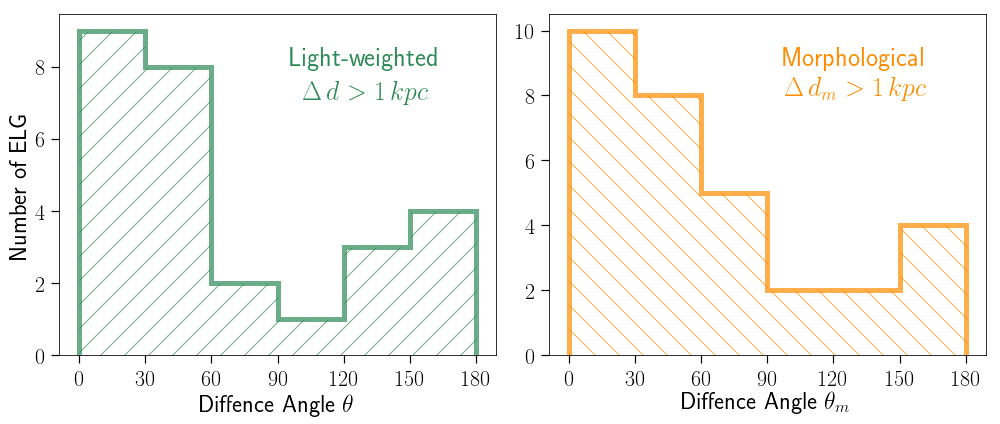

In [100]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,6))
props = zip(['/', '\\'], ['','m'], ['seagreen', 'darkorange'],
            ['Light-weighted', 'Morphological'])
for ax, (hat, sub, c, txt), d_angle in zip([ax1,ax2], props,
                                           [d_angle_iso, d_angle_mor]):
    ax.hist(d_angle, histtype="step", bins=np.linspace(0,180,7),
             color=c, linewidth=1.2, hatch=hat, lw=5, alpha=0.7,zorder=2)

    ax.text(0.7,0.85, txt, color=c, ha='center', transform=ax.transAxes, fontsize=26)
    ax.text(0.7,0.75, '$\Delta\,d_{%s}>1\,kpc$'%sub, color=c, ha='center', transform=ax.transAxes, fontsize=26)
    ax.set_xlabel(r'Diffence Angle  $\theta_{%s}$'%sub, fontsize=24)
    ax.tick_params(axis="both", labelsize=22)
    ax.set_xticks(np.linspace(0,180,7))
    
ax1.set_ylabel("Number of ELG", fontsize=24)
plt.tight_layout()
# plt.savefig('./pic/A2465_angle_hist_SN2_5_v3.pdf')

In [79]:
from scipy.stats import ks_2samp
ks_2samp(d_angle_iso, stats.uniform.rvs(size=10000, loc=0., scale=180))

Ks_2sampResult(statistic=0.34552962962962963, pvalue=0.002262552409610523)

In [80]:
from scipy.stats import ks_2samp
ks_2samp(d_angle_mor, stats.uniform.rvs(size=10000, loc=0., scale=180))

Ks_2sampResult(statistic=0.2618290322580645, pvalue=0.023286819648325012)

In [82]:
cen_D = SkyCoord(datacube_D.header['TARGETR'], datacube_D.header['TARGETD'], unit=(u.hourangle,u.deg))
cen_D

<SkyCoord (ICRS): (ra, dec) in deg
    (339.88541667, -5.75611111)>

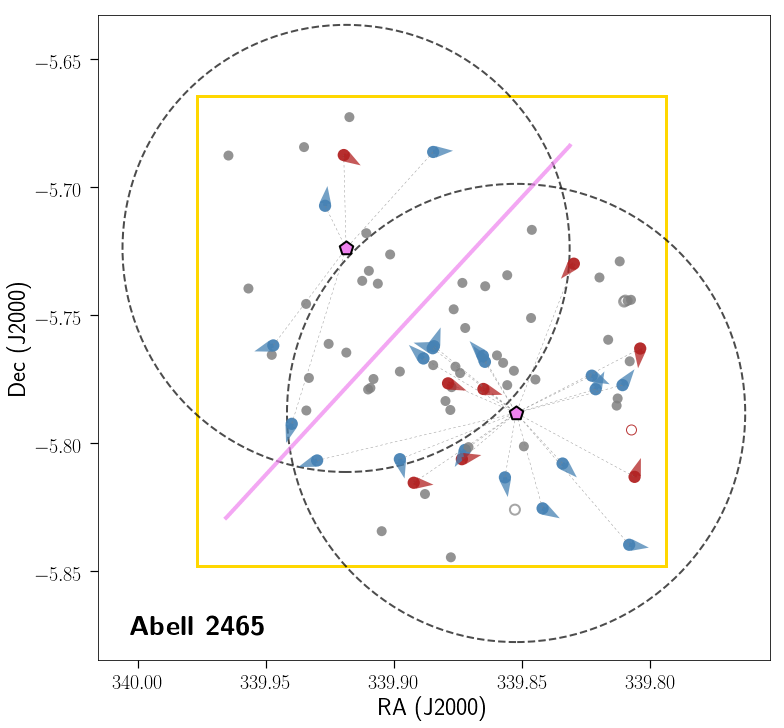

In [88]:
fig, ax = plt.subplots(figsize=(11,11))
ax.set_xlim(tab_A2465C['ra'].max() + 0.04, tab_A2465C['ra'].min() - 0.05)
ax.set_ylim(tab_A2465C['dec'].min() - 0.04, tab_A2465C['dec'].max() + 0.04)
plt.xlabel("RA (J2000)", fontsize=24)
plt.ylabel("Dec (J2000)", fontsize=24)

coord_BCG = ((339.91869588, -5.72394458), (339.85233922, -5.78816229))
for i, R_v in enumerate([1.21,1.24]):
    plt.scatter(coord_BCG[i][0],coord_BCG[i][1], s=200, edgecolor="k", color="violet", marker='p', lw=2., alpha=1,zorder=3)
    circle = plt.Circle(coord_BCG[i], R_v*u.Mpc/len_pix*0.322/3600, color='k', ls="--", lw=2., alpha=0.7, fill=False) #1 Mpc
    ax.add_artist(circle)
    
plt.imshow(Z_bound, cmap='seismic')

for k, (ID, ra, dec, z, pa, theta) in enumerate(zip(tab_A2465C['ID'], tab_A2465C['ra'], tab_A2465C['dec'], tab_A2465C['z'],
                                                    tab_A2465C['pa_ISO-D'], tab_A2465C['diff_angle_ISO-D'])):
    color = "steelblue" if theta<90 else "firebrick"
    if (cond_iso & (abs(tab_A2465C['z']-0.245)<=0.012))[k]:
        plt.scatter(ra, dec, s=150, color=color, edgecolors="none", alpha=0.95,zorder=2)

        x, y = datacube_D.wcs.all_world2pix(ra, dec, 0)
        member = Z_bound[np.int(y), np.int(x)] - 1
        plt.plot((ra, coord_BCG[member][0]), (dec,coord_BCG[member][1]), color="gray",
                 ls="--", dashes=(5,5),  lw=.5, alpha=0.8, zorder=2)

        plt.arrow(ra, dec, -np.sin(pa*np.pi/180)*0.001, -np.cos(pa*np.pi/180)*0.001, 
                  color=color, width=0.0015, lw=0.01, alpha=0.75, zorder=2)
        
    elif (cond_iso& (abs(tab_A2465C['z']-0.245)>0.012))[k]:
        plt.scatter(ra, dec, s=100, facecolors="none", edgecolors=color, alpha=0.9,zorder=2)
    elif theta>0:
        if (abs(tab_A2465C['z']-0.245)<=0.012)[k]:
            plt.scatter(ra, dec, s=100, facecolor='gray', edgecolor="none", lw=2, alpha=0.85, zorder=2)
        else:
            plt.scatter(ra, dec, s=100, facecolor='none', color="gray", lw=2, alpha=0.7, zorder=1)
            
L_field = (1024*len_pix/distance_cluster*180/np.pi).value
rec = patches.Rectangle((cen_D.ra.value-L_field, cen_D.dec.value-L_field), 2*L_field, 2*L_field,
                        linewidth=3, edgecolor='gold', facecolor='none', zorder=1)
ax.add_patch(rec)
ax.tick_params(axis="both", labelsize=20)

bound = (Y_bound>200) & (Y_bound<2048-200)
ra_bound, dec_bound = datacube_D.wcs.all_pix2world(X_bound[bound],Y_bound[bound], 0)
plt.plot(ra_bound, dec_bound, color='violet', ls='-', lw=4, alpha=0.7)
ax.text(0.15, 0.05, r'\textbf{Abell 2465}', ha='center', va='center', fontsize=28, transform=ax.transAxes)
plt.tight_layout()
# plt.savefig('./pic/spatial_A2465_SN2_5_v3.pdf')

Combining Two

/home/qliu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in less
/home/qliu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in less_equal
/home/qliu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in less_equal
/home/qliu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in greater


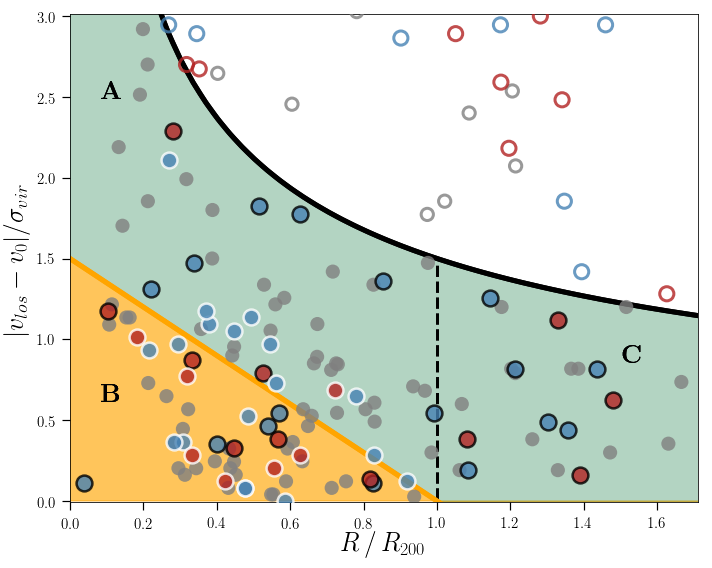

In [106]:
plt.figure(figsize=(10,8))
ax = plt.subplot(111)
    
thre_A2390 = 0.85
cond_iso_A2390 = condition_1(tab['cen_offset_ISO-D'], tab['cen_offset_std_ISO-D'],
                             tab['z'], z0=0.228, dz=0.015, thre=thre_A2390) # 1kpc

r_n_A2390, v_n_A2390, conds_angle_A2390, conds_clus_A2390 = separate_member_space(tab, cond_iso_A2390, z0=0.228,
                                                                                  v_vir=v_vir_A2390, l_R200=l_R200_A2390,
                                                                                  R_vir=R_vir_A2390, M_vir=M_2390, 
                                                                                  bound_type="inv-sq",
                                                                                  centroid_type='ISO-D')
draw_phase_diagram(r_n_A2390, v_n_A2390, conds_angle_A2390, conds_clus_A2390,
                   R_vir=R_vir_A2390, bound_type="inv-sq",
                   thre=thre_A2390, add_text=False, ID=tab["ID"], ax=ax)

thre_A2465 = 0.81
cond_iso_A2465 = condition_1(tab_A2465C['cen_offset_ISO-D'], tab_A2465C['cen_offset_std_ISO-D'],
                       tab_A2465C['z'], z0=0.245, dz=0.035, thre=thre_A2465) # 1kpc

r_n_A2465, v_n_A2465, conds_angle_A2465, conds_clus_A2465 = separate_member_space(tab_A2465C, cond_iso_A2465, z0=0.245,
                                                                                  v_vir=v_vir_A2465, l_R200=l_R200_A2465,
                                                                                  R_vir=R_vir_A2465, M_vir=M_A2465,
                                                                                  bound_type="inv-sq",
                                                                                  centroid_type='ISO-D')
draw_phase_diagram(r_n_A2465, v_n_A2465, conds_angle_A2465, conds_clus_A2465, R_vir=R_vir_A2465, bound_type="inv-sq",
                   thre=thre_A2465, r2=1.7, mec="w", add_text=False, ID=tab["ID"], ax=ax)